In [155]:
import pandas as pd
from gensim.models import Word2Vec
import nltk
from nltk.stem import WordNetLemmatizer
import string
from nltk.tokenize import word_tokenize
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import xgboost as xgb

In [156]:
nltk.download('words')

[nltk_data] Downloading package words to
[nltk_data]     /Users/syedmuneeb/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [157]:
words = set(nltk.corpus.words.words())

In [158]:
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

In [159]:
def punctuation_removal(text):
    punctuations = string.punctuation
    return text.str.replace(fr"([{punctuations}])", repl="", regex=True)

Stop Word Removal

In [160]:
def remove_stopwords(text):
    stopwords = nltk.corpus.stopwords.words('english')
    output= [i for i in text if i not in stopwords]
    return output

Lemmatization

In [161]:
def lemmatizer(text):
    wordnet_lemmatizer = WordNetLemmatizer()
    return [wordnet_lemmatizer.lemmatize(word) for word in text]

Preprocess Function

In [162]:
def preprocess_text(text):
    #removing punctuations
    text_no_punc = punctuation_removal(text)
    #lowercase
    text_lowercase = text_no_punc.str.lower()
    # print(text_lowercase)
    #tokenization
    text_tokenized =text_lowercase.apply(word_tokenize)
    #stopword removal
    text_no_stop = text_tokenized.apply(remove_stopwords)
    #lemmatization
    text_lemmatized = text_no_stop.apply(lemmatizer)
    
    #list to string
    preprocessed_text = text_lemmatized.apply(lambda x: " ".join(w for w in x \
         if w.lower() in words and w.isalpha() and len(w)>1))
    return preprocessed_text

In [163]:
train_df['preprocessed_reviews'] =  preprocess_text(train_df['review'])
test_df['preprocessed_reviews'] =  preprocess_text(test_df['review'])

In [164]:
sentences = pd.concat([train_df['preprocessed_reviews'], test_df['preprocessed_reviews']],axis=0)
train_sentences = list(sentences.apply(str.split).values)

In [165]:
model = Word2Vec(sentences=train_sentences, 
                 sg=1, 
                 vector_size=100,
                 window=5,  
                 workers=4,
                 min_count=1)

In [166]:
train_w2vec = []
test_w2vec = []

for index, row in train_df.iterrows():
    mean_w2vec = (np.mean([model.wv[token] for token in row['preprocessed_reviews'].split()], axis=0)).tolist()
    train_w2vec.append(mean_w2vec)
    
for index, row in test_df.iterrows():
    mean_w2vec = (np.mean([model.wv[token] for token in row['preprocessed_reviews'].split()], axis=0)).tolist()
    test_w2vec.append(mean_w2vec)

In [167]:
X_train = pd.DataFrame.from_records(train_w2vec)
X_test = pd.DataFrame.from_records(test_w2vec)

In [168]:
y_train = train_df['sentiment']
y_test = test_df['sentiment']

In [169]:
classes_mapping = {"positive":1, "negative":0}

In [170]:
xgb_classifier = xgb.XGBClassifier()
xgb_classifier.fit(X_train, y=y_train.replace(classes_mapping))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [171]:
random_forest_classifier = RandomForestClassifier()
random_forest_classifier.fit(X_train, y=y_train)

RandomForestClassifier()

In [172]:
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(X_train, y=y_train)

KNeighborsClassifier()

In [173]:
ada = AdaBoostClassifier()
ada.fit(X_train, y=y_train)

/opt/homebrew/Caskroom/miniforge/base/envs/sentiment-analysis/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier()

In [153]:
# Train Accuracy
xgb_predicted_labels = xgb_classifier.predict(X_train)
rf_predicted_labels = random_forest_classifier.predict(X_train)
knn_predicted_labels = knn_classifier.predict(X_train)
ada_predicted_labels = ada.predict(X_train)

print(f"XGB Train Accuracy: {accuracy_score(y_train.replace(classes_mapping), xgb_predicted_labels)*100}%")
print(f"RF Train Accuracy: {accuracy_score(y_train, rf_predicted_labels)*100}%")
print(f"KNN Train Accuracy: {accuracy_score(y_train, knn_predicted_labels)*100}%")
print(f"Ada Train Accuracy: {accuracy_score(y_train, ada_predicted_labels)*100}%")

XGB Train Accuracy: 98.54333333333334%
RF Train Accuracy: 100.0%
KNN Train Accuracy: 87.90666666666667%
Ada Train Accuracy: 83.65666666666667%


#### Predicting Test Labels

In [174]:
# Test Accuracy
xgb_predicted_labels = xgb_classifier.predict(X_test)
rf_predicted_labels = random_forest_classifier.predict(X_test)
knn_predicted_labels = knn_classifier.predict(X_test)
ada_predicted_labels = ada.predict(X_test)

print(f"XGB Test Accuracy: {accuracy_score(y_test.replace(classes_mapping), xgb_predicted_labels)*100}%")
print(f"RF Test Accuracy: {accuracy_score(y_test, rf_predicted_labels)*100}%")
print(f"KNN Test Accuracy: {accuracy_score(y_test, knn_predicted_labels)*100}%")
print(f"Ada Test Accuracy: {accuracy_score(y_test, ada_predicted_labels)*100}%")

XGB Test Accuracy: 86.195%
RF Test Accuracy: 84.49%
KNN Test Accuracy: 82.17999999999999%
Ada Test Accuracy: 83.52000000000001%


In [175]:
# Confusion Matrix
xgb_mat = confusion_matrix(y_test.replace(classes_mapping), xgb_predicted_labels, normalize= 'true')
knn_mat = confusion_matrix(y_test, knn_predicted_labels, normalize= 'true')
rf_mat = confusion_matrix(y_test, rf_predicted_labels, normalize= 'true')
ada_mat = confusion_matrix(y_test, ada_predicted_labels, normalize= 'true')

In [179]:
def confusion_matrix_heatmap(mat, data, title):
    labels = data['sentiment'].unique()
    sns.heatmap(mat.T, square = True, annot=True, xticklabels=labels, yticklabels=labels, vmin=0, vmax=1, cmap="Blues")
    plt.title(title)
    plt.xlabel("true labels")
    plt.ylabel("predicted label")
    plt.show()

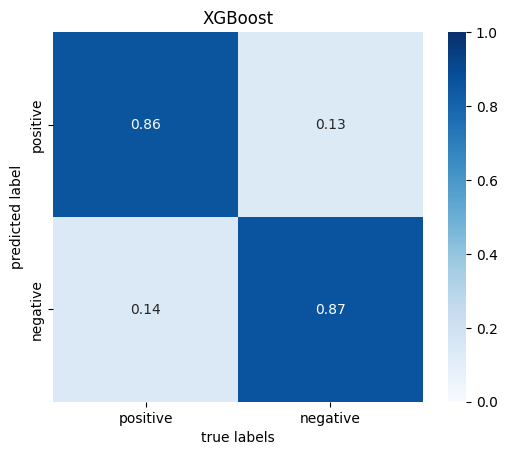

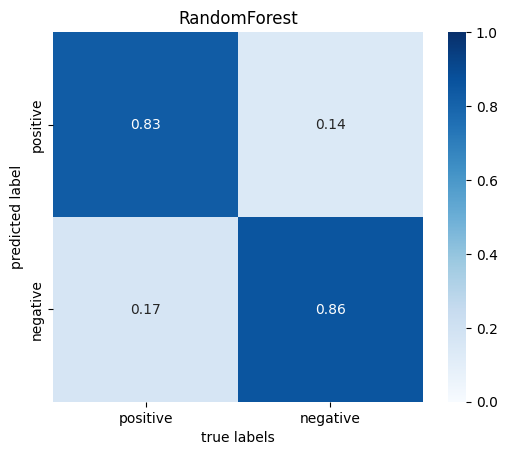

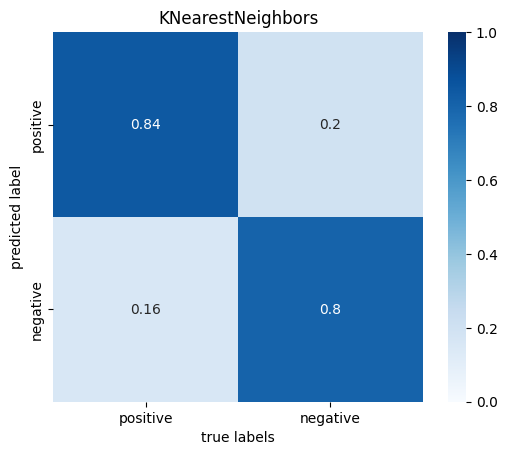

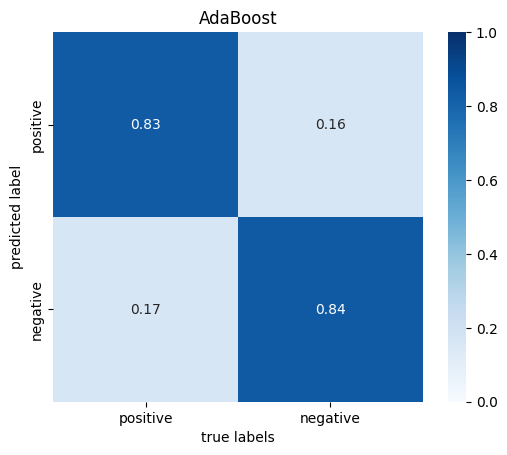

In [181]:
# Confusion Matrix
confusion_matrix_heatmap(xgb_mat, test_df, "XGBoost")
confusion_matrix_heatmap(rf_mat, test_df, "RandomForest")
confusion_matrix_heatmap(knn_mat, test_df, "KNearestNeighbors")
confusion_matrix_heatmap(ada_mat, test_df, "AdaBoost")